In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Загрузка данных
df = pd.read_csv('realAWSCloudwatch/elb_request_count_8c0756.csv')

# Просмотр первых строк датасета
print("\nПервые строки датасета:")
print(df.head())

# Информация о структуре датасета
print("\nСтруктура датасета:")
print(df.info())

# Статистический анализ
print("\nСтатистика датасета:")
print(df.describe())

# Проверка на пропуски в данных
print("\nПроверка на пропуски в данных:")
print(df.isnull().sum())

# Преобразование столбца времени в datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)


Первые строки датасета:
             timestamp  value
0  2014-04-10 00:04:00   94.0
1  2014-04-10 00:09:00   56.0
2  2014-04-10 00:14:00  187.0
3  2014-04-10 00:19:00   95.0
4  2014-04-10 00:24:00   51.0

Структура датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
None

Статистика датасета:
             value
count  4032.000000
mean     61.837054
std      56.664703
min       1.000000
25%      15.000000
50%      48.000000
75%      89.000000
max     656.000000

Проверка на пропуски в данных:
timestamp    0
value        0
dtype: int64


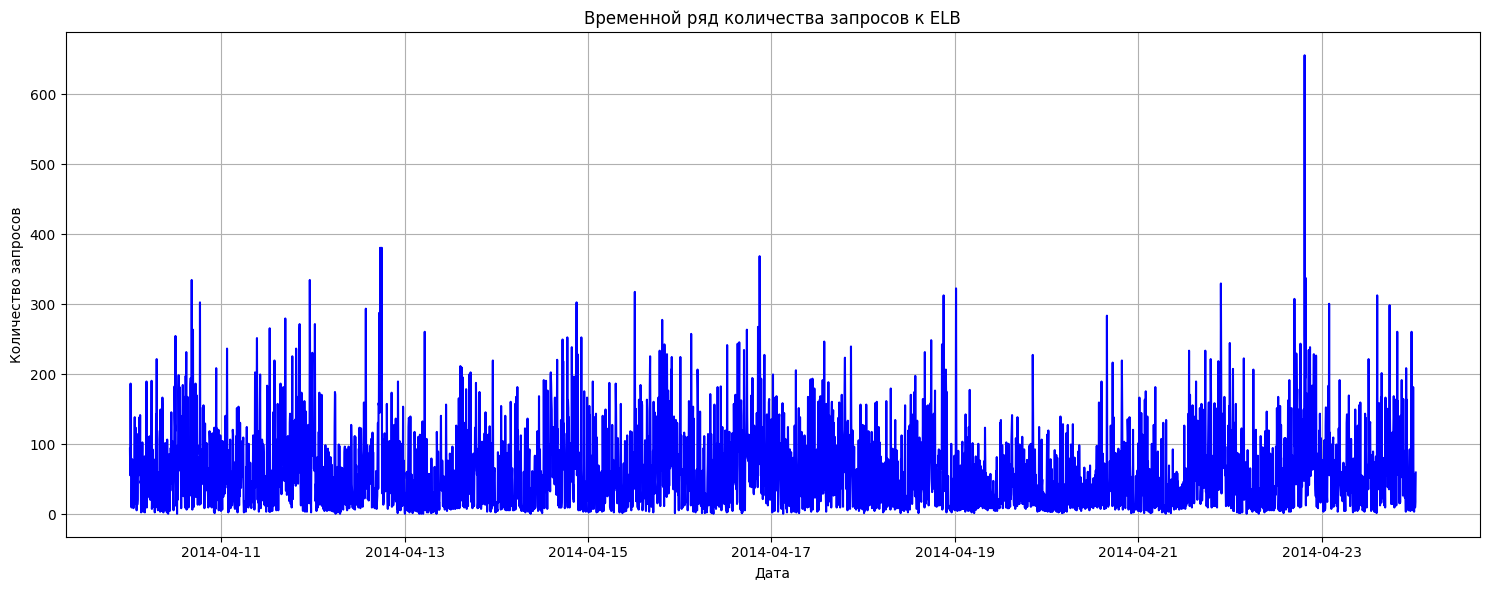

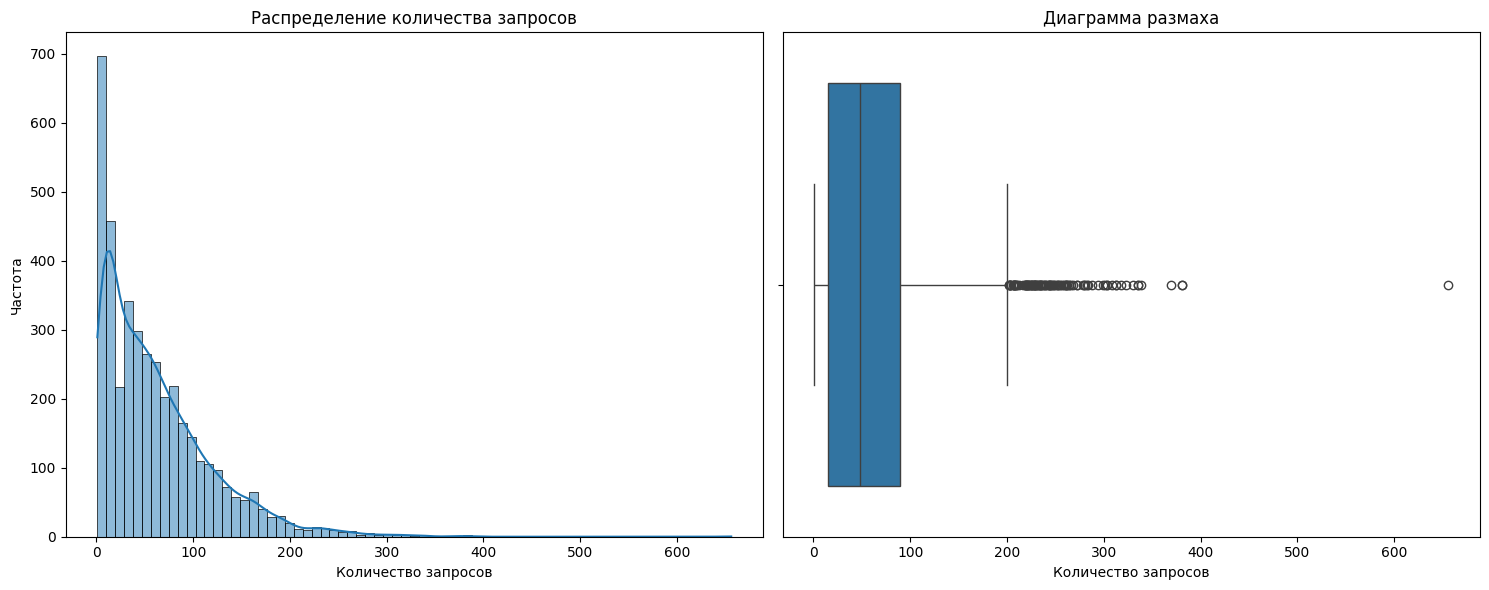

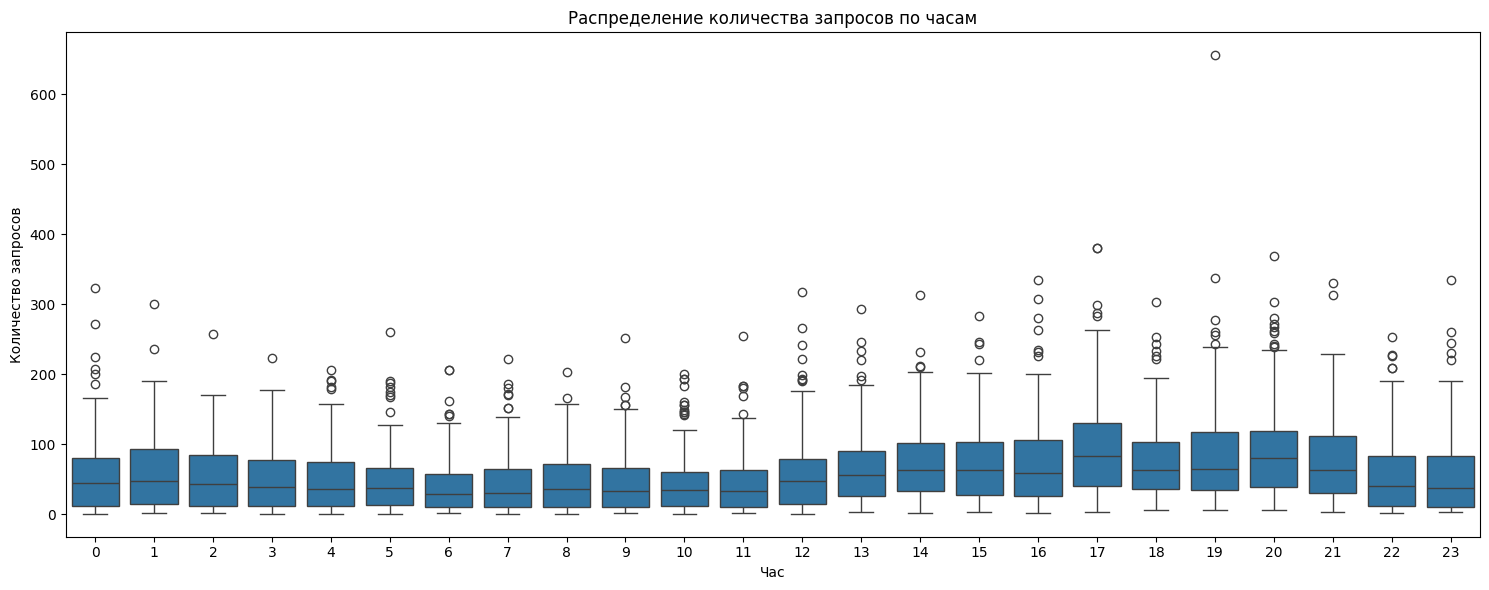

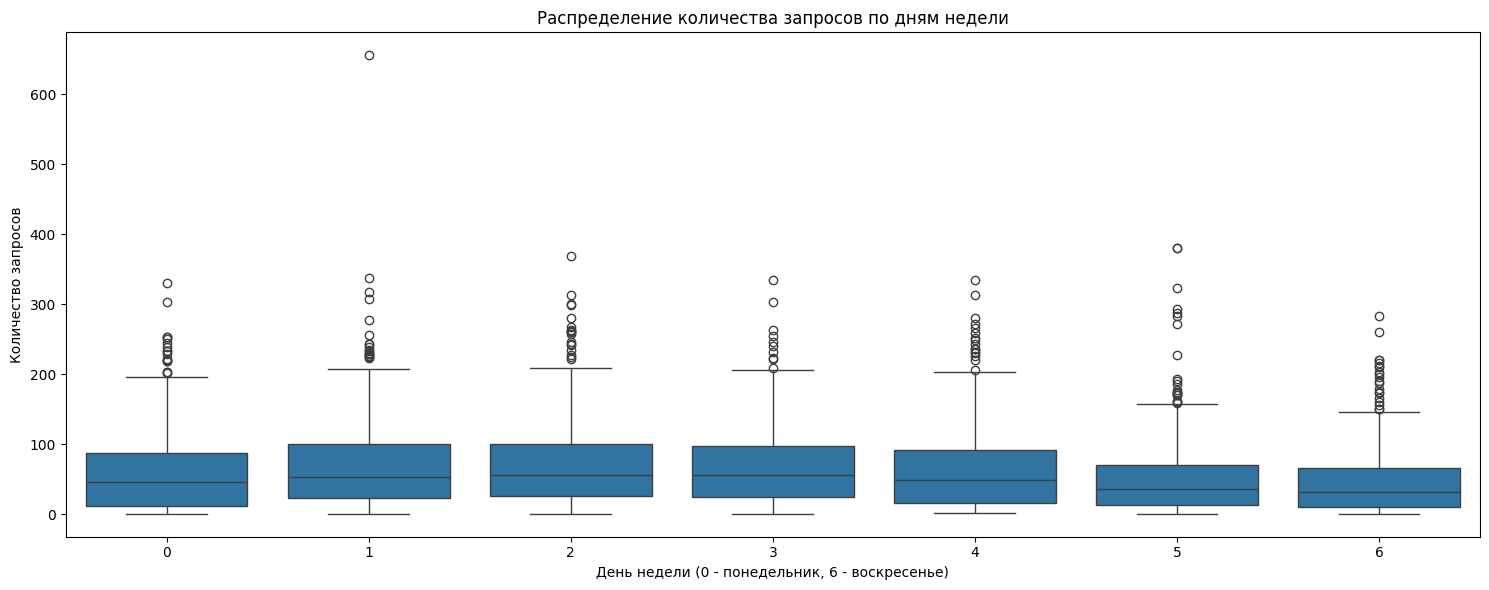

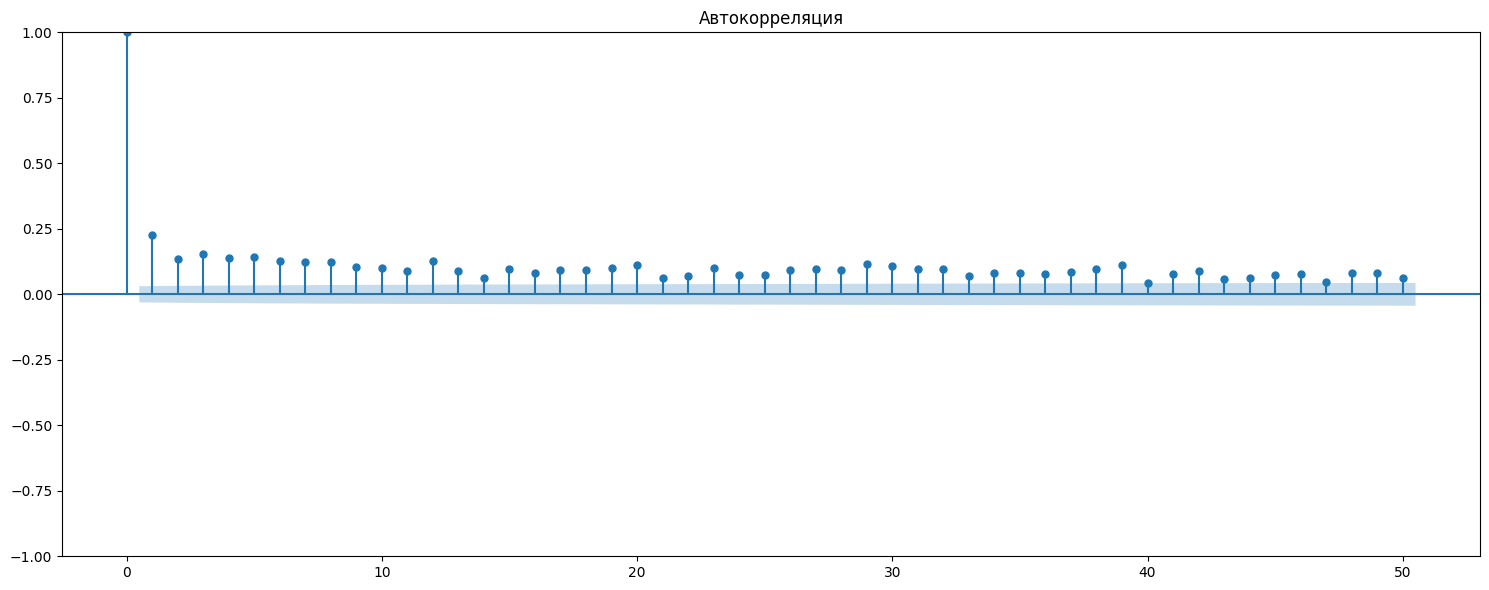

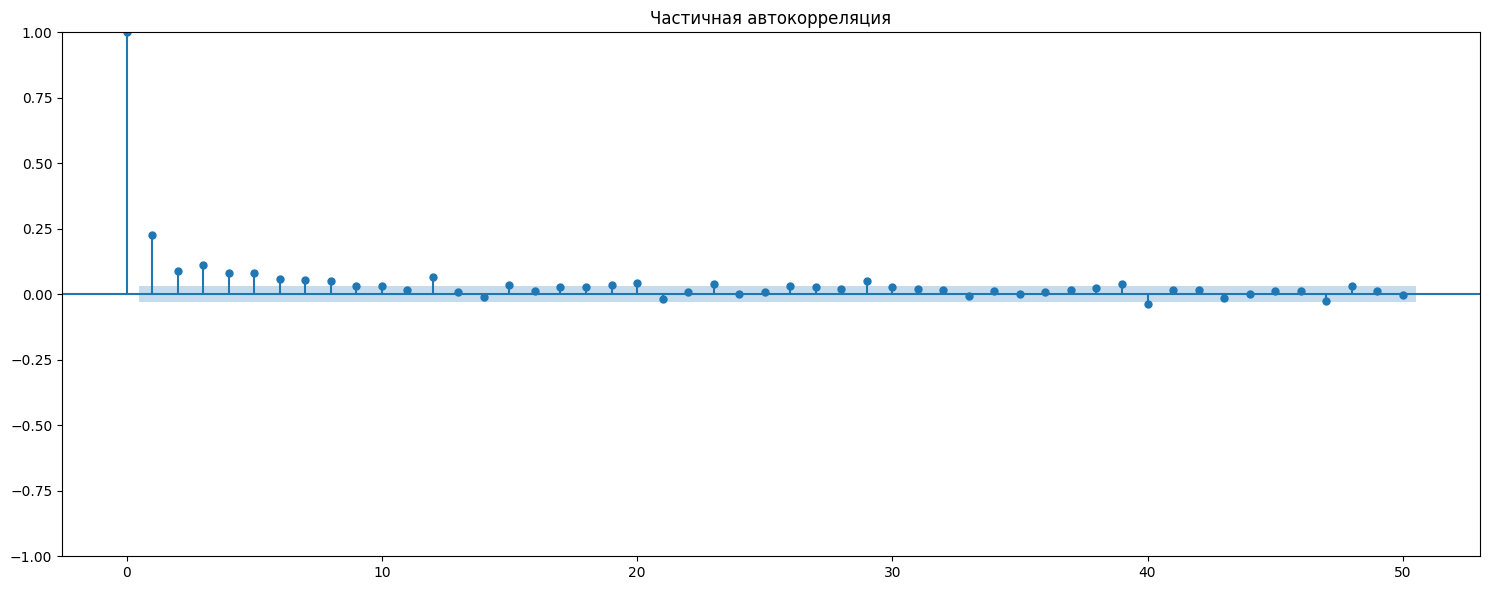

In [6]:
# 2. Разведочный анализ данных (EDA)
# ----------------------------------

# Построение временного ряда
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['value'], color='blue')
plt.title('Временной ряд количества запросов к ELB')
plt.xlabel('Дата')
plt.ylabel('Количество запросов')
plt.grid(True)
plt.tight_layout()
plt.show()

# Анализ распределения данных
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['value'], kde=True)
plt.title('Распределение количества запросов')
plt.xlabel('Количество запросов')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['value'])
plt.title('Диаграмма размаха')
plt.xlabel('Количество запросов')

plt.tight_layout()
plt.show()

# Анализ временных паттернов
# Создание дополнительных временных признаков
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Анализ почасовой активности
plt.figure(figsize=(15, 6))
sns.boxplot(x='hour', y='value', data=df)
plt.title('Распределение количества запросов по часам')
plt.xlabel('Час')
plt.ylabel('Количество запросов')
plt.tight_layout()
plt.show()

# Анализ по дням недели
plt.figure(figsize=(15, 6))
sns.boxplot(x='dayofweek', y='value', data=df)
plt.title('Распределение количества запросов по дням недели')
plt.xlabel('День недели (0 - понедельник, 6 - воскресенье)')
plt.ylabel('Количество запросов')
plt.tight_layout()
plt.show()

# Анализ автокорреляции
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 6))
plot_acf(df['value'], lags=50, ax=plt.gca())
plt.title('Автокорреляция')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plot_pacf(df['value'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляция')
plt.tight_layout()
plt.show()

In [7]:
# 3. Подготовка данных для модели
# -----------------------------

# Функция для создания временных окон
def create_sequences(data, seq_length):
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

# Масштабирование данных
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df[['value']])

# Определение длины последовательности
seq_length = 24  # Используем 24 часа для прогнозирования

# Создание последовательностей
X, y = create_sequences(data_scaled, seq_length)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Создание датасетов и даталоадеров
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# 4. Определение модели LSTM с PyTorch
# -----------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        
        # Полносвязный слой
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        # Инициализация скрытого состояния
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        
        # Прямой проход через LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Берем последний временной шаг
        out = self.linear(out[:, -1, :])
        return out

# Создание экземпляра модели
model = LSTMModel(input_size=1, hidden_layer_size=100, output_size=1, num_layers=2)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Эпоха 5/50, Потери на обучении: 0.0277, Потери на тесте: 0.0326
Эпоха 10/50, Потери на обучении: 0.0272, Потери на тесте: 0.0320
Эпоха 15/50, Потери на обучении: 0.0269, Потери на тесте: 0.0316
Эпоха 20/50, Потери на обучении: 0.0266, Потери на тесте: 0.0314
Эпоха 25/50, Потери на обучении: 0.0264, Потери на тесте: 0.0313
Эпоха 30/50, Потери на обучении: 0.0263, Потери на тесте: 0.0312
Эпоха 35/50, Потери на обучении: 0.0263, Потери на тесте: 0.0312
Эпоха 40/50, Потери на обучении: 0.0262, Потери на тесте: 0.0312
Эпоха 45/50, Потери на обучении: 0.0262, Потери на тесте: 0.0312
Эпоха 50/50, Потери на обучении: 0.0261, Потери на тесте: 0.0312


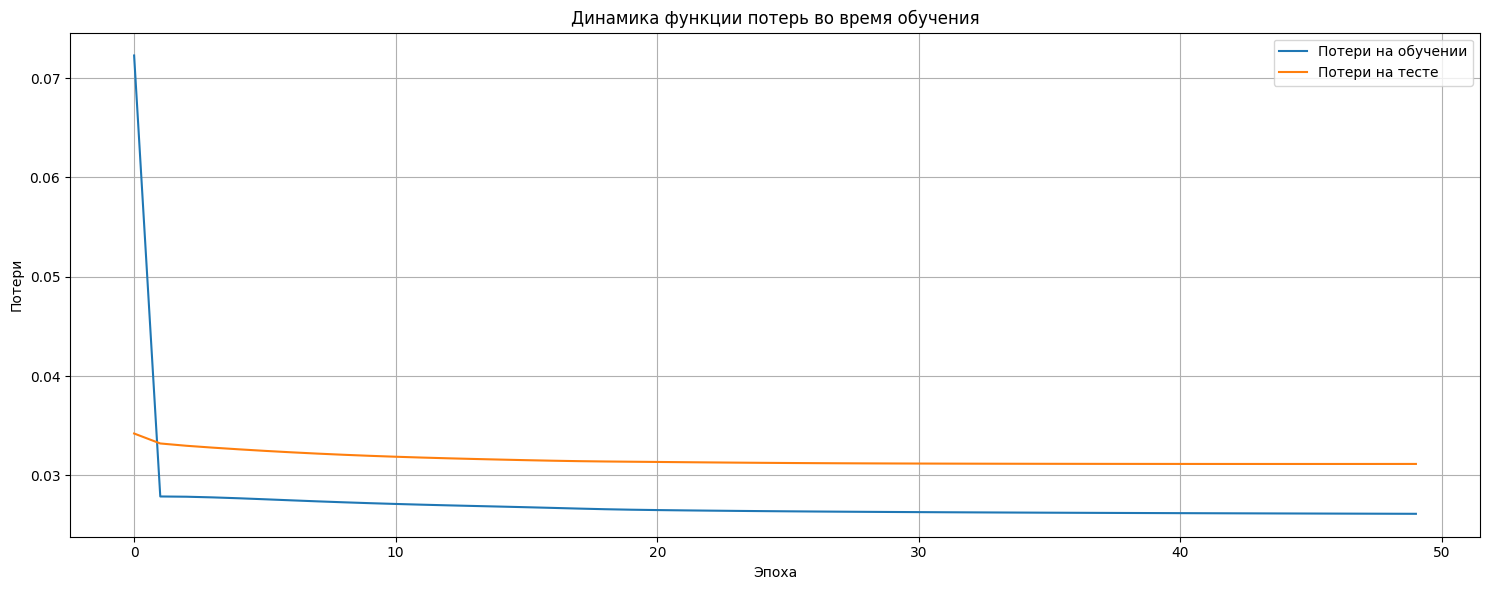

In [ ]:
# 5. Обучение модели
# -----------------

# Параметры обучения
num_epochs = 50
train_losses = []
test_losses = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Преобразование формы входных данных для LSTM
        X_batch = X_batch.view(X_batch.shape[0], seq_length, 1)
        
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Вычисление потерь на тестовой выборке
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.view(X_batch.shape[0], seq_length, 1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    # Сохранение потерь
    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    
    # Вывод информации о процессе обучения
    if (epoch + 1) % 5 == 0:
        print(f'Эпоха {epoch+1}/{num_epochs}, Потери на обучении: {train_losses[-1]:.4f}, Потери на тесте: {test_losses[-1]:.4f}')

# Визуализация процесса обучения
plt.figure(figsize=(15, 6))
plt.plot(range(num_epochs), train_losses, label='Потери на обучении')
plt.plot(range(num_epochs), test_losses, label='Потери на тесте')
plt.title('Динамика функции потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

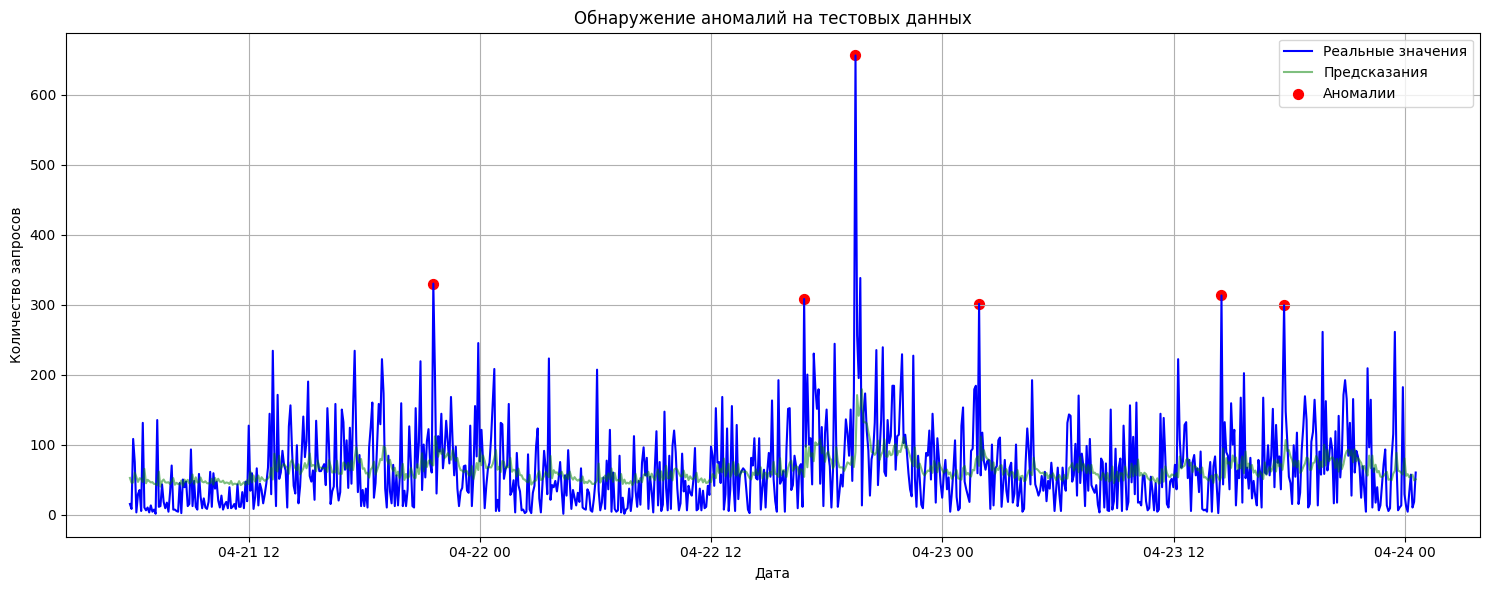


Количество обнаруженных аномалий: 6 из 802 точек (0.75%)


In [10]:
# 6. Тестирование модели для обнаружения аномалий
# ---------------------------------------------

# Прогнозирование на тестовой выборке
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(X_batch.shape[0], seq_length, 1)
        outputs = model(X_batch)
        
        # Сохранение предсказаний и реальных значений
        predictions.extend(outputs.detach().numpy())
        actual.extend(y_batch.detach().numpy())

# Преобразование в numpy массивы
predictions = np.array(predictions)
actual = np.array(actual)

# Вычисление ошибки предсказания
mse = np.mean((predictions - actual) ** 2, axis=1)

# Нахождение аномалий (используем порог как среднее + 3 стандартных отклонения)
threshold = np.mean(mse) + 3 * np.std(mse)
anomalies = mse > threshold

# Возвращаем значения в исходный масштаб
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

# Получение временного ряда для тестовой выборки
test_index = df.index[seq_length:-1][-len(predictions):]

# Построение графика с аномалиями
plt.figure(figsize=(15, 6))
plt.plot(test_index, actual_rescaled, label='Реальные значения', color='blue')
plt.plot(test_index, predictions_rescaled, label='Предсказания', color='green', alpha=0.5)
plt.scatter(test_index[anomalies], actual_rescaled[anomalies], color='red', label='Аномалии', s=50)
plt.title('Обнаружение аномалий на тестовых данных')
plt.xlabel('Дата')
plt.ylabel('Количество запросов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Подсчет количества обнаруженных аномалий
num_anomalies = np.sum(anomalies)
print(f'\nКоличество обнаруженных аномалий: {num_anomalies} из {len(predictions)} точек ({num_anomalies/len(predictions)*100:.2f}%)')


Топ-10 аномалий:
              timestamp  actual  prediction       mse
452 2014-04-22 19:29:00   656.0   89.169586  2.995599
189 2014-04-21 21:34:00   330.0   70.220627  0.629197
680 2014-04-23 14:29:00   313.0   54.935555  0.620917
420 2014-04-22 16:49:00   308.0   53.763969  0.602631
529 2014-04-23 01:54:00   301.0   69.472916  0.499782
719 2014-04-23 17:44:00   299.0   81.831650  0.439714
788 2014-04-23 23:29:00   261.0   62.319111  0.368035
743 2014-04-23 19:44:00   261.0   67.960953  0.347430
455 2014-04-22 19:44:00   338.0  153.433578  0.317602
89  2014-04-21 13:14:00   234.0   50.090561  0.315345


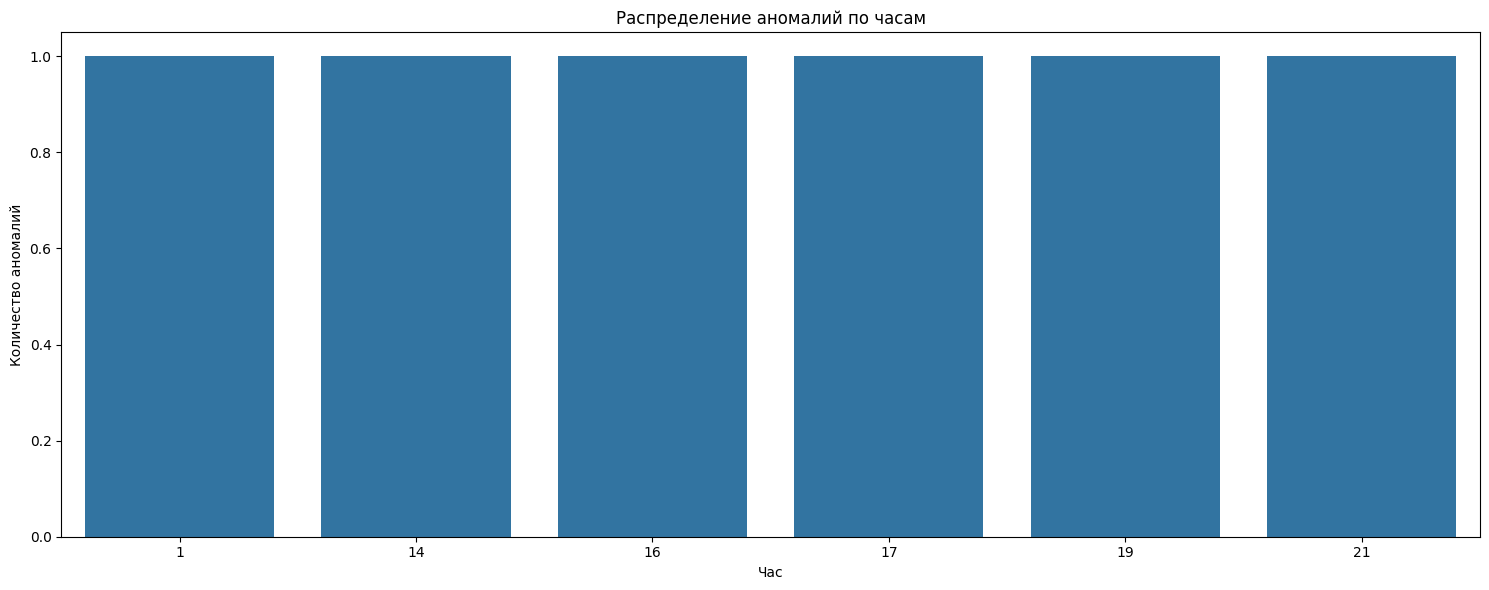

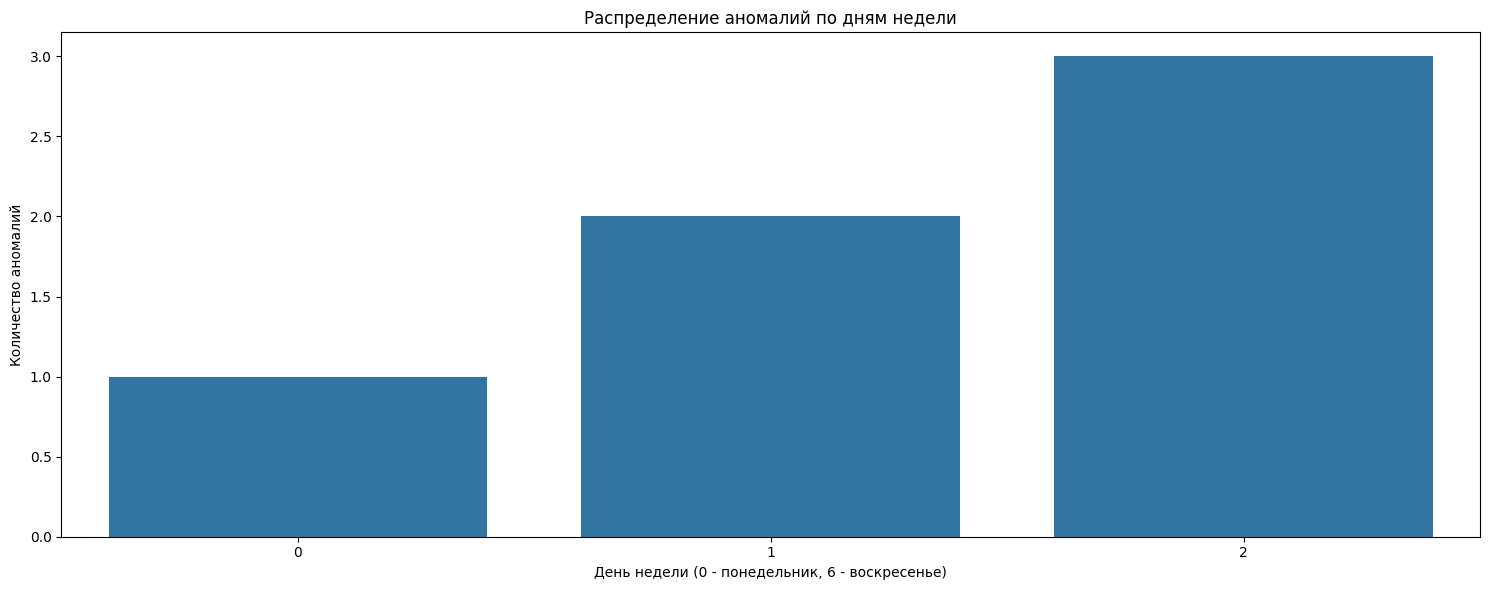

In [12]:
# 7. Анализ аномалий
# -----------------

# Создание DataFrame для результатов
results = pd.DataFrame({
    'timestamp': test_index,
    'actual': actual_rescaled,
    'prediction': predictions_rescaled,
    'mse': mse,
    'is_anomaly': anomalies
})

# Сортировка по степени аномальности
results_sorted = results.sort_values(by='mse', ascending=False)

# Вывод топ-10 аномалий
print("\nТоп-10 аномалий:")
print(results_sorted.head(10)[['timestamp', 'actual', 'prediction', 'mse']])

# Характеристики аномалий
anomaly_data = results[results['is_anomaly'] == True]

# Суточное распределение аномалий
anomaly_data['hour'] = anomaly_data['timestamp'].dt.hour
anomaly_data['day'] = anomaly_data['timestamp'].dt.day
anomaly_data['dayofweek'] = anomaly_data['timestamp'].dt.dayofweek

plt.figure(figsize=(15, 6))
sns.countplot(x='hour', data=anomaly_data)
plt.title('Распределение аномалий по часам')
plt.xlabel('Час')
plt.ylabel('Количество аномалий')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.countplot(x='dayofweek', data=anomaly_data)
plt.title('Распределение аномалий по дням недели')
plt.xlabel('День недели (0 - понедельник, 6 - воскресенье)')
plt.ylabel('Количество аномалий')
plt.tight_layout()
plt.show()

In [14]:
# 8. Автоматизация обнаружения аномалий на новых данных
# --------------------------------------------------

# Функция для обнаружения аномалий в новом временном ряду
def detect_anomalies(model, new_data, scaler, seq_length, threshold=None):
    """
    Обнаружение аномалий в новых данных с помощью обученной модели
    
    Parameters:
    -----------
    model : PyTorch модель
        Обученная модель для предсказания
    new_data : numpy.ndarray
        Новые данные в виде массива
    scaler : MinMaxScaler
        Скейлер для нормализации данных
    seq_length : int
        Длина последовательности для предсказания
    threshold : float, опционально
        Порог для определения аномалий. Если None, рассчитывается как среднее + 3*std
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame с результатами анализа и обнаруженными аномалиями
    """
    # Масштабирование данных
    scaled_data = scaler.transform(new_data.reshape(-1, 1))
    
    # Создание последовательностей
    X = []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
    X = np.array(X)
    
    # Преобразование в тензор
    X_tensor = torch.FloatTensor(X)
    X_tensor = X_tensor.view(X_tensor.shape[0], seq_length, 1)
    
    # Предсказание
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).numpy()
    
    # Реальные значения
    actual = scaled_data[seq_length:].reshape(-1, 1)
    
    # Вычисление ошибки
    mse = np.mean((predictions - actual) ** 2, axis=1)
    
    # Определение порога аномалий
    if threshold is None:
        threshold = np.mean(mse) + 3 * np.std(mse)
    
    # Определение аномалий
    anomalies = mse > threshold
    
    # Возврат к исходному масштабу
    predictions_rescaled = scaler.inverse_transform(predictions).flatten()
    actual_rescaled = scaler.inverse_transform(actual).flatten()
    
    # Создание DataFrame с результатами
    results = pd.DataFrame({
        'actual': actual_rescaled,
        'prediction': predictions_rescaled,
        'mse': mse,
        'is_anomaly': anomalies
    })
    
    return results, threshold

In [15]:
# 9. Выводы и рекомендации
# -----------------------

# Сводка результатов
print("\n=== Сводка результатов анализа аномалий ===")
print(f"Всего точек данных: {len(results)}")
print(f"Обнаружено аномалий: {num_anomalies} ({num_anomalies/len(results)*100:.2f}%)")
print(f"Средняя ошибка предсказания (MSE): {np.mean(mse):.6f}")
print(f"Порог аномалий: {threshold:.6f}")

# Сохранение модели для будущего использования
torch.save(model.state_dict(), 'lstm_anomaly_detection_model.pth')
print("\nМодель сохранена в 'lstm_anomaly_detection_model.pth'")



=== Сводка результатов анализа аномалий ===
Всего точек данных: 802
Обнаружено аномалий: 6 (0.75%)
Средняя ошибка предсказания (MSE): 0.032148
Порог аномалий: 0.396798

Модель сохранена в 'lstm_anomaly_detection_model.pth'
